In [ ]:
!python -m pip install --upgrade setuptools
!pip install git+https://github.com/tky823/ssspy.git@v0.1.1

In [2]:
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import IPython.display as ipd

In [3]:
from ssspy.utils.dataset import download_sample_speech_data

In [4]:
n_sources = 4
max_duration = 10
sisec2010_tag = "dev1_female4"
n_fft, hop_length = 4096, 2048

In [5]:
waveform_src_img, sample_rate = download_sample_speech_data(
    n_sources=n_sources,
    sisec2010_tag=sisec2010_tag,
    max_duration=max_duration,
    conv=True,
) # (n_channels, n_sources, n_samples)
waveform_mix = np.sum(waveform_src_img, axis=1)  # (n_channels, n_samples)

In [6]:
import functools

In [7]:
from ssspy.bss.ilrma import GaussILRMA as GaussILRMAbase
from ssspy.bss.ilrma import GGDILRMA as GGDILRMAbase

In [8]:
def max_flooring(x, eps=1e-12):
    # by default: 1e-12
    total = np.sum(x < eps)

    if total > 10:
        print(total, x.shape)

    return np.maximum(x, eps)

In [9]:
class GaussILRMA(GaussILRMAbase):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.loss_diff_basis = []
        self.loss_diff_activation = []

    def update_source_model(self) -> None:
        if self.partitioning:
            self.update_latent()

        loss1 = self.compute_loss()
        self.update_basis()
        loss2 = self.compute_loss()
        self.update_activation()
        loss3 = self.compute_loss()

        self.loss_diff_basis.append(loss1 - loss2)
        self.loss_diff_activation.append(loss2 - loss3)

In [10]:
class GGDILRMA(GGDILRMAbase):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.loss_diff_basis = []
        self.loss_diff_activation = []

    def update_source_model(self) -> None:
        if self.partitioning:
            self.update_latent()

        loss1 = self.compute_loss()
        self.update_basis()
        loss2 = self.compute_loss()
        self.update_activation()
        loss3 = self.compute_loss()

        self.loss_diff_basis.append(loss1 - loss2)
        self.loss_diff_activation.append(loss2 - loss3)

## Gauss-ILRMA

In [11]:
ilrma = GaussILRMA(
    n_basis=2,
    spatial_algorithm="IP1",
    domain=2,
    partitioning=False,
    flooring_fn=functools.partial(max_flooring, eps=1e-15), # use 1e-15
    normalization="projection_back",
    rng=np.random.default_rng(42),
)
print(ilrma)

GaussILRMA(n_basis=2, spatial_algorithm=IP1, domain=2, partitioning=False, normalization=projection_back, scale_restoration=True, record_loss=True, reference_id=0)


In [12]:
_, _, spectrogram_mix = ss.stft(waveform_mix, window="hann", nperseg=n_fft, noverlap=n_fft-hop_length)

In [13]:
spectrogram_est = ilrma(spectrogram_mix, n_iter=100)

38 (4, 2049, 2)
19 (4, 2049, 2)
12 (4, 2049, 2)
12 (4, 2049, 2)
16 (4, 2049, 2)
22 (4, 2049, 2)
21 (4, 2049, 2)
31 (4, 2049, 2)
29 (4, 2049, 2)
29 (4, 2049, 2)
33 (4, 2049, 2)
45 (4, 2049, 2)
42 (4, 2049, 2)
46 (4, 2049, 2)
48 (4, 2049, 2)
49 (4, 2049, 2)
48 (4, 2049, 2)
47 (4, 2049, 2)
52 (4, 2049, 2)
51 (4, 2049, 2)
54 (4, 2049, 2)
54 (4, 2049, 2)
58 (4, 2049, 2)
60 (4, 2049, 2)
61 (4, 2049, 2)
65 (4, 2049, 2)
66 (4, 2049, 2)
70 (4, 2049, 2)
76 (4, 2049, 2)
82 (4, 2049, 2)
87 (4, 2049, 2)
90 (4, 2049, 2)
98 (4, 2049, 2)
103 (4, 2049, 2)
111 (4, 2049, 2)
117 (4, 2049, 2)
120 (4, 2049, 2)
128 (4, 2049, 2)
134 (4, 2049, 2)
145 (4, 2049, 2)
153 (4, 2049, 2)
160 (4, 2049, 2)
170 (4, 2049, 2)
180 (4, 2049, 2)
191 (4, 2049, 2)
193 (4, 2049, 2)
210 (4, 2049, 2)
235 (4, 2049, 2)
245 (4, 2049, 2)
256 (4, 2049, 2)
266 (4, 2049, 2)
275 (4, 2049, 2)
280 (4, 2049, 2)
281 (4, 2049, 2)
290 (4, 2049, 2)
300 (4, 2049, 2)
311 (4, 2049, 2)
320 (4, 2049, 2)
326 (4, 2049, 2)
334 (4, 2049, 2)
347 (4, 2049,

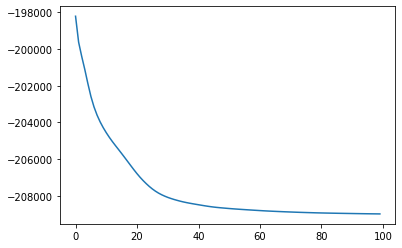

In [14]:
plt.figure()
plt.plot(ilrma.loss[1:])
plt.show()
plt.close()

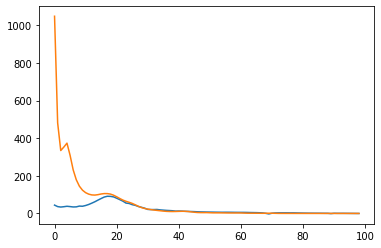

In [15]:
plt.figure()
plt.plot(ilrma.loss_diff_basis[1:])
plt.plot(ilrma.loss_diff_activation[1:])
plt.show()
plt.close()

In [16]:
np.sum(np.array(ilrma.loss_diff_basis) < 0), np.sum(np.array(ilrma.loss_diff_activation) < 0)

(3, 0)

## GGD-ILRMA

In [17]:
ilrma = GGDILRMA(
    n_basis=2,
    beta=1.8,
    spatial_algorithm="IP1", # You can set "IP" instead of "IP1".
    domain=2,
    partitioning=False, # w/o partitioning function
    flooring_fn=max_flooring,
    normalization=False,
    rng=np.random.default_rng(42),
)
print(ilrma)

GGDILRMA(n_basis=2, beta=1.8, spatial_algorithm=IP1, domain=2, partitioning=False, normalization=False, scale_restoration=True, record_loss=True, reference_id=0)


In [18]:
_, _, spectrogram_mix = ss.stft(waveform_mix, window="hann", nperseg=n_fft, noverlap=n_fft-hop_length)

In [19]:
spectrogram_est = ilrma(spectrogram_mix, n_iter=200)

11 (4, 2049, 2)
12 (4, 2049, 2)
13 (4, 2049, 2)
14 (4, 2049, 2)
14 (4, 2049, 2)
14 (4, 2049, 2)
14 (4, 2049, 2)
15 (4, 2049, 2)
18 (4, 2049, 2)
18 (4, 2049, 2)
18 (4, 2049, 2)
22 (4, 2049, 2)
21 (4, 2049, 2)
22 (4, 2049, 2)
21 (4, 2049, 2)
20 (4, 2049, 2)
21 (4, 2049, 2)
24 (4, 2049, 2)
24 (4, 2049, 2)
29 (4, 2049, 2)
30 (4, 2049, 2)
31 (4, 2049, 2)
35 (4, 2049, 2)
39 (4, 2049, 2)
43 (4, 2049, 2)
49 (4, 2049, 2)
51 (4, 2049, 2)
52 (4, 2049, 2)
56 (4, 2049, 2)
59 (4, 2049, 2)
65 (4, 2049, 2)
71 (4, 2049, 2)
84 (4, 2049, 2)
91 (4, 2049, 2)
104 (4, 2049, 2)
112 (4, 2049, 2)
122 (4, 2049, 2)
139 (4, 2049, 2)
140 (4, 2049, 2)
146 (4, 2049, 2)
155 (4, 2049, 2)
159 (4, 2049, 2)
166 (4, 2049, 2)
175 (4, 2049, 2)
184 (4, 2049, 2)
192 (4, 2049, 2)
205 (4, 2049, 2)
214 (4, 2049, 2)
234 (4, 2049, 2)
265 (4, 2049, 2)
12 (4, 2, 80)
281 (4, 2049, 2)
13 (4, 2, 80)
296 (4, 2049, 2)
13 (4, 2, 80)
308 (4, 2049, 2)
13 (4, 2, 80)
321 (4, 2049, 2)
13 (4, 2, 80)
333 (4, 2049, 2)
13 (4, 2, 80)
344 (4, 2049, 2

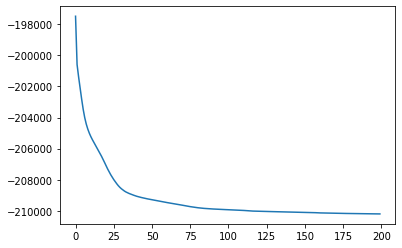

In [20]:
plt.figure()
plt.plot(ilrma.loss[1:])
plt.show()
plt.close()

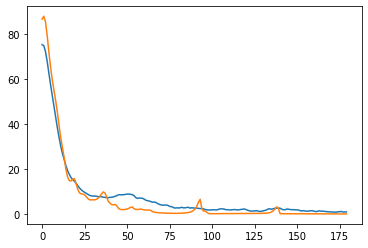

In [21]:
plt.figure()
plt.plot(ilrma.loss_diff_basis[20:])
plt.plot(ilrma.loss_diff_activation[20:])
plt.show()
plt.close()

In [22]:
np.sum(np.array(ilrma.loss_diff_basis) < 0), np.sum(np.array(ilrma.loss_diff_activation) < 0)

(0, 0)